- which subgraphs actually touch the final layer?
- which subgraphs actually touch the final layer and contain the correct class as a node in the subgraph?
- are nearest neighbors represented as nearest neighbors in graph space?
- what are the nearest neighbors of the additional graph structure induced by the adversary?

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pt_activation.models.alexnet import AlexNet

PERCENTILE = 90

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/cifar/projected_gradient_descent/alexnet_cifar.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='../../data/cifar', train=False,
                        download=True, transform = transforms.Compose(
                        [transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])), 
                        batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 32*32*3))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_induced_filtration(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(32*32*3)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 32*32*3))
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_induced_filtration(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(32*32*3)
            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def get_adv_dist(i,j):
    return np.linalg.norm(i-j,2)

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/alexnet_cifar.pt'
model = AlexNet()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, nms, wms, ims = create_filtrations(model, 1, 1)

Files already downloaded and verified
Filtration: 0
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.79814693 0.79814693 0.07151769 0.21455308 0.02664709 0.03181982
 0.0541022  0.37871538 0.01563126 0.00178134 0.00516319]
creating filtration object...
filtration size 2669145
Sorting filtration...


In [7]:
adv_df, adv_nms, adv_wms, adv_ims = create_adversary_filtrations(model, 1, 1, adversaries)

torch.Size([1000, 3, 32, 32])
Filtration: 0
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.79672423 0.79672423 0.07146484 0.21439451 0.02509836 0.03050124
 0.05142241 0.35995687 0.01512615 0.0017276  0.00500421]
creating filtration object...
filtration size 2713966
Sorting filtration...


In [8]:
# print(np.linalg.norm(ims[1]-adv_ims[1]))
print(np.linalg.norm(ims[0]-adv_ims[0]))

0.44283105342589796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


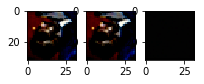

In [9]:
fig, axes = plt.subplots(1,3,figsize=(3,3))
axes[0].imshow(ims[0].reshape(3,32,32).T, interpolation='nearest')
axes[1].imshow(adv_ims[0].reshape(3,32,32).T, interpolation='nearest')
axes[2].imshow(np.absolute((ims[0]-adv_ims[0])).reshape(3,32,32).T)

In [10]:
ids = [{v: k for k, v in nm.items()} for nm in nms]
adv_ids = [{v: k for k, v in nm.items()} for nm in adv_nms]

In [11]:
def create_sample_graphs(res_df, ids, wms):
    sample_graphs = []
    dgms = []
    lifetimes = []
    for s in range(res_df.shape[0]):
        print(s)
        wm = wms[s]
        tnms = ids[s]
        subgraphs = {}
        f = res_df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgm = dion.init_diagrams(m,f)[0]
        dgms.append(dgm)
        for i,c in enumerate(m):
            if len(c) == 2:
                w = f[i].data
                if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                    w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
                elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                    w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
                if False: #tnms[f[c[0].index][0]] in subgraphs:
                    subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(tnms[f[c[0].index][0]]):
                            if tnms[f[c[1].index][0]] in subgraphs:
                                v.add_node(tnms[f[c[1].index][0]])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                            else:
                                v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        subgraphs[tnms[f[c[0].index][0]]] = g
                        
        sample_graphs.append(subgraphs)
        lifetimes.append(create_lifetimes(f, subgraphs,dgm,ids[s]))
    return sample_graphs, dgms, lifetimes

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]] 
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes
    

In [12]:
sample_graphs, dgms, lifetimes = create_sample_graphs(res_df, ids, wms)

0


In [13]:
adv_sample_graphs, adv_dgms, adv_lifetimes = create_sample_graphs(adv_df, adv_ids, adv_wms)

0


In [14]:
res_df.head(10)

,class,filtration,loss,prediction
0,3,"[(70865), (70867), (70865, 70867), (70864), (7...",-2.912672,3


In [15]:
adv_df.head(10)

,class,filtration,loss,prediction
0,3,"[(70919), (70921), (70919, 70921), (70918), (7...",-3.00033,5


In [16]:
goi = 0

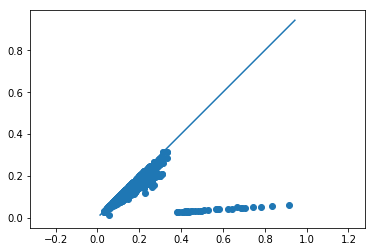

In [17]:
dion.plot.plot_diagram(dgms[goi])

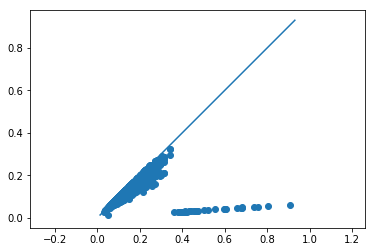

In [18]:
dion.plot.plot_diagram(adv_dgms[goi])

In [19]:
print(sample_graphs[goi].keys())

dict_keys([(8, 0, 19), (7, 207, 0), (8, 0, 49), (8, 0, 148), (7, 94, 0), (7, 87, 0), (7, 235, 0), (7, 104, 0), (7, 202, 0), (7, 178, 0), (8, 0, 2), (7, 184, 0), (7, 175, 0), (8, 0, 10), (7, 78, 0), (7, 36, 0), (8, 0, 149), (8, 0, 141), (7, 185, 0), (7, 64, 0), (7, 6, 0), (7, 120, 0), (7, 240, 0), (7, 131, 0), (7, 75, 0), (7, 9, 0), (7, 162, 1), (7, 102, 0), (7, 123, 0), (7, 195, 2), (7, 170, 0), (7, 8, 0), (8, 0, 54), (7, 130, 2), (8, 0, 84), (7, 136, 2), (7, 200, 2), (2, 20, 256), (2, 20, 257), (2, 20, 277), (2, 20, 278), (2, 20, 298), (2, 20, 299), (2, 60, 362), (2, 60, 363), (2, 60, 383), (2, 60, 384), (2, 10, 285), (2, 10, 286), (2, 10, 306), (2, 10, 307), (2, 20, 381), (2, 20, 402), (2, 20, 360), (2, 18, 339), (2, 18, 340), (2, 18, 360), (2, 18, 361), (2, 18, 318), (2, 18, 319), (2, 20, 235), (2, 20, 236), (2, 10, 287), (2, 10, 308), (2, 18, 298), (2, 18, 299), (2, 18, 320), (2, 18, 341), (2, 55, 277), (2, 55, 298), (2, 38, 426), (2, 38, 427), (2, 55, 147), (2, 55, 148), (2, 55, 1

In [20]:
print(adv_sample_graphs[goi].keys())

dict_keys([(8, 0, 19), (7, 207, 0), (8, 0, 49), (7, 94, 0), (8, 0, 148), (7, 235, 0), (7, 202, 0), (7, 104, 0), (7, 87, 0), (7, 178, 0), (7, 184, 0), (8, 0, 2), (8, 0, 10), (7, 175, 0), (7, 123, 0), (7, 36, 0), (8, 0, 149), (7, 78, 0), (7, 64, 0), (8, 0, 141), (7, 185, 0), (8, 0, 6), (7, 75, 0), (8, 0, 195), (7, 162, 1), (7, 120, 0), (7, 131, 0), (7, 8, 0), (7, 240, 0), (7, 102, 0), (7, 118, 2), (7, 9, 0), (7, 28, 0), (2, 20, 256), (2, 20, 257), (2, 20, 277), (2, 20, 278), (2, 60, 362), (2, 60, 363), (2, 60, 383), (2, 60, 384), (2, 10, 285), (2, 10, 286), (2, 10, 306), (2, 10, 307), (2, 20, 381), (2, 20, 402), (2, 20, 360), (2, 20, 235), (2, 20, 236), (2, 18, 318), (2, 18, 319), (2, 18, 339), (2, 18, 340), (2, 18, 360), (2, 18, 361), (2, 10, 287), (2, 10, 308), (2, 18, 298), (2, 18, 299), (2, 18, 320), (2, 18, 341), (2, 55, 277), (2, 55, 298), (2, 38, 426), (2, 38, 427), (2, 10, 284), (2, 10, 305), (2, 43, 110), (2, 43, 111), (2, 43, 131), (2, 43, 132), (2, 43, 152), (2, 43, 153), (2, 

In [21]:
print(len(lifetimes[goi]))
lifetimes[goi]

1278


{(8, 0, 19): 0.9437981247901917,
 (7, 207, 0): 0.8555202558636665,
 (8, 0, 49): 0.7748246379196644,
 (8, 0, 148): 0.7305503077805042,
 (7, 94, 0): 0.6939930394291878,
 (7, 87, 0): 0.6579514928162098,
 (7, 235, 0): 0.6452756598591805,
 (7, 104, 0): 0.6383017003536224,
 (7, 202, 0): 0.6165730282664299,
 (7, 178, 0): 0.5984488613903522,
 (8, 0, 2): 0.5787722058594227,
 (7, 184, 0): 0.5403978750109673,
 (7, 175, 0): 0.5304515995085239,
 (8, 0, 10): 0.5282861515879631,
 (7, 78, 0): 0.4917701780796051,
 (7, 36, 0): 0.4726429767906666,
 (8, 0, 149): 0.4612649902701378,
 (8, 0, 141): 0.4610004164278507,
 (7, 185, 0): 0.4477122090756893,
 (7, 64, 0): 0.4326577000319958,
 (7, 6, 0): 0.4212942626327276,
 (7, 120, 0): 0.41497057117521763,
 (7, 240, 0): 0.40917981788516045,
 (7, 131, 0): 0.3996804151684046,
 (7, 75, 0): 0.39868077263236046,
 (7, 9, 0): 0.397629177197814,
 (7, 162, 1): 0.3963427785784006,
 (7, 102, 0): 0.3969897050410509,
 (7, 123, 0): 0.38941003382205963,
 (7, 195, 2): 0.3869657516

In [22]:
print(len(adv_lifetimes[goi]))
adv_lifetimes[goi]

1268


{(8, 0, 19): 0.9303663969039917,
 (7, 207, 0): 0.8467090763151646,
 (8, 0, 49): 0.7486040219664574,
 (7, 94, 0): 0.7045476958155632,
 (8, 0, 148): 0.6860523484647274,
 (7, 235, 0): 0.6359436437487602,
 (7, 202, 0): 0.6301282569766045,
 (7, 104, 0): 0.6320168673992157,
 (7, 87, 0): 0.615086704492569,
 (7, 178, 0): 0.5670713670551777,
 (7, 184, 0): 0.5583995655179024,
 (8, 0, 2): 0.5551109351217747,
 (8, 0, 10): 0.5135692805051804,
 (7, 175, 0): 0.48487719148397446,
 (7, 123, 0): 0.46472548320889473,
 (7, 36, 0): 0.43949760124087334,
 (8, 0, 149): 0.4362904168665409,
 (7, 78, 0): 0.42891500517725945,
 (7, 64, 0): 0.42760784551501274,
 (8, 0, 141): 0.4266019333153963,
 (7, 185, 0): 0.4104146044701338,
 (8, 0, 6): 0.4061170555651188,
 (7, 75, 0): 0.40175708569586277,
 (8, 0, 195): 0.39404876343905926,
 (7, 162, 1): 0.3854565154761076,
 (7, 120, 0): 0.38553686812520027,
 (7, 131, 0): 0.3784096799790859,
 (7, 8, 0): 0.3783677238970995,
 (7, 240, 0): 0.3724206369370222,
 (7, 102, 0): 0.364579

In [23]:
sgk = (8, 0, 19)
asgk = sgk

In [ ]:
# fig = plt.figure(figsize=(12, 12))
# draw_neural_net(fig.gca(), .1, .9, .1, .9, sample_graphs[goi][sgk], n_layers=4)

options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(sample_graphs[goi][sgk], **options)

options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(adv_sample_graphs[goi][asgk], **options)

In [24]:
sample_graphs[goi][sgk].edges(data=True)

EdgeDataView([((8, 0, 19), (7, 19, 1), {'weight': 0.9437981}), ((8, 0, 19), (7, 19, 0), {'weight': 0.9225533}), ((8, 0, 19), (7, 19, 2), {'weight': 0.87245345}), ((8, 0, 19), (7, 19, 3), {'weight': 0.8250615}), ((8, 0, 19), (9, 0, 2332), {'weight': 0.06729775}), ((8, 0, 19), (9, 0, 929), {'weight': 0.06483136}), ((8, 0, 19), (9, 0, 1012), {'weight': -0.06468732}), ((8, 0, 19), (9, 0, 2487), {'weight': -0.063861445}), ((8, 0, 19), (9, 0, 2564), {'weight': 0.06365062}), ((8, 0, 19), (9, 0, 362), {'weight': 0.06359351}), ((8, 0, 19), (9, 0, 2519), {'weight': 0.063527875}), ((8, 0, 19), (9, 0, 3347), {'weight': 0.063397355}), ((8, 0, 19), (9, 0, 3070), {'weight': 0.06328572}), ((8, 0, 19), (9, 0, 2592), {'weight': 0.063109756}), ((8, 0, 19), (9, 0, 1662), {'weight': 0.06283011}), ((8, 0, 19), (9, 0, 805), {'weight': -0.06221558}), ((8, 0, 19), (9, 0, 705), {'weight': -0.06206275}), ((8, 0, 19), (9, 0, 2768), {'weight': -0.061970524}), ((8, 0, 19), (9, 0, 2621), {'weight': 0.061847944}), ((

In [25]:
adv_sample_graphs[goi][asgk].edges(data=True)

EdgeDataView([((8, 0, 19), (7, 19, 1), {'weight': 0.9303664}), ((8, 0, 19), (7, 19, 0), {'weight': 0.9186091}), ((8, 0, 19), (7, 19, 2), {'weight': 0.87007076}), ((8, 0, 19), (7, 19, 3), {'weight': 0.8098085}), ((8, 0, 19), (9, 0, 2332), {'weight': 0.06634}), ((8, 0, 19), (9, 0, 929), {'weight': 0.0639087}), ((8, 0, 19), (9, 0, 1012), {'weight': -0.06376672}), ((8, 0, 19), (9, 0, 2487), {'weight': -0.06295259}), ((8, 0, 19), (9, 0, 2564), {'weight': 0.062744774}), ((8, 0, 19), (9, 0, 362), {'weight': 0.06268847}), ((8, 0, 19), (9, 0, 2519), {'weight': 0.06262377}), ((8, 0, 19), (9, 0, 3347), {'weight': 0.062495112}), ((8, 0, 19), (9, 0, 3070), {'weight': 0.062385067}), ((8, 0, 19), (9, 0, 2592), {'weight': 0.062211607}), ((8, 0, 19), (9, 0, 1662), {'weight': 0.06193594}), ((8, 0, 19), (9, 0, 805), {'weight': -0.06133016}), ((8, 0, 19), (9, 0, 705), {'weight': -0.061179504}), ((8, 0, 19), (9, 0, 2768), {'weight': -0.061088584}), ((8, 0, 19), (9, 0, 2621), {'weight': 0.06096775}), ((8, 0

In [26]:
for k in sample_graphs[goi]:
    if len(sample_graphs[goi][k].edges()) != len(adv_sample_graphs[goi][k].edges()):
        print(k)

(8, 0, 19)
(7, 207, 0)
(8, 0, 148)
(7, 94, 0)
(7, 87, 0)
(7, 235, 0)
(7, 104, 0)
(7, 202, 0)
(7, 178, 0)
(7, 184, 0)
(7, 175, 0)
(7, 78, 0)
(7, 64, 0)


KeyError: (7, 6, 0)

In [27]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [28]:
hamming_distance(sample_graphs[goi][sgk],adv_sample_graphs[goi][asgk])

0.19987289482046394

In [29]:
weighted_edge_distance(sample_graphs[goi][sgk],adv_sample_graphs[goi][asgk])

0.029647769210582653

In [30]:
adv_thru = -1
sim_mat = np.zeros((len(sample_graphs[goi]),len(adv_sample_graphs[goi])))
sk = list(sample_graphs[goi].keys())
ak = list(adv_sample_graphs[goi].keys())[:adv_thru]
for i in range(len(sk)):
    g = sample_graphs[goi][sk[i]]
    for j in range(len(ak)):
        ag = adv_sample_graphs[goi][ak[j]]
        sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)
        

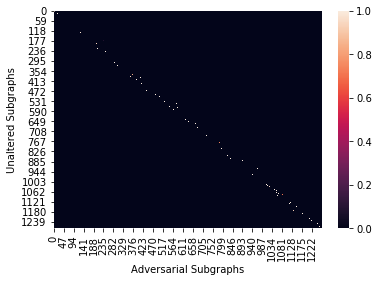

In [31]:
# ax = sns.heatmap(sim_mat[~np.all(sim_mat == 0, axis=1)], linewidths=.01)
ax = sns.heatmap(sim_mat, linewidths=0)
plt.yticks(rotation=0)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/alexnet_cifar/heatmap.png', format='png', dpi=500)

In [ ]:
# gois = [sample_graphs[goi][k] for k in sample_graphs[goi].keys()]
# all_goi = nx.compose_all(gois)

In [ ]:
# adv_gois = [adv_sample_graphs[goi][k] for k in adv_sample_graphs[goi].keys()]
# adv_all_goi = nx.compose_all(adv_gois)

In [ ]:
# combs = []
# for sg in sample_graphs:
#     combs.append(nx.compose_all([sg[k] for k in sg.keys()]))
# adv_combs = []
# for sg in adv_sample_graphs:
#     adv_combs.append(nx.compose_all([sg[k] for k in sg.keys()]))

In [ ]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

In [ ]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

comb_sim_mat = np.zeros((len(sample_graphs), len(sample_graphs)))
sidx = list(sorted_res_df.index)
for i in range(len(sample_graphs)):
    ix = sidx[i]
    for j in range(len(sample_graphs)):
        jx = sidx[j]
        comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[ix],sample_graphs[jx],lifetimes[ix],lifetimes[jx])
        

In [ ]:
csmdf = pd.DataFrame(comb_sim_mat, columns=sorted_res_df['prediction'], index=sorted_res_df['prediction'])

In [ ]:
# ax = sns.heatmap(comb_sim_mat)
# plt.yticks(rotation=0)
# plt.ylabel('Unaltered Graphs')
# plt.xlabel('Adversarial Graphs')
# plt.savefig('comb_heatmap.png', format='png', dpi=500)

# ax = sns.heatmap(comb_sim_mat, xticklabels=sorted_res_df['prediction'],yticklabels=sorted_res_df['prediction'])
ax = sns.heatmap(csmdf, xticklabels=3, yticklabels=2)
plt.yticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=4)
plt.ylabel('Unaltered Graphs')
plt.xlabel('Unaltered Graphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/alexnet_cifar/comb_heatmap_no_adv.png', format='png', dpi=500)

In [ ]:
comb_sim_mat2 = np.zeros((len(sample_graphs), len(sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(sample_graphs)):
        comb_sim_mat2[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],sample_graphs[j],lifetimes[i],lifetimes[j])
    

In [ ]:
ngoi = 2
res_df.iloc[ngoi].head()

In [ ]:
res_df.iloc[comb_sim_mat2[ngoi,:].argsort()[-10:][::-1]]

In [ ]:
res_df.iloc[comb_sim_mat2[0,:].argsort()[-10:][::-1]]